In [1]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
%matplotlib inline

In [2]:
#parameters

M = 16 # lattices

dim = 2
dirs = 5

nlat = int(np.ceil(np.log2(M)))
nlinks = int(np.ceil(np.log2(dirs)))

w = (2/6,1/6,1/6,1/6,1/6)
e = (0,-1,1,-1,1) #center, left, right, down, up
cs = 1/np.sqrt(3)   ##speed of sound
u = (0, 0.2, 0.2, 0.15, 0.15)  ##advection 

colls = []
for i in range(dirs):
    colls.append(w[i]*(1+e[i]*u[i]/cs**2))
    
lambdas = [np.arccos(i) for i in colls]

# colls, lambdas
colls

[0.3333333333333333,
 0.06666666666666668,
 0.2666666666666666,
 0.09166666666666669,
 0.2416666666666666]

In [3]:
def createLambda(oper, isC1 = True):
    
    s = bin(oper)[2:]
    s = '0'*int((np.ceil(np.log2(dirs))-len(s))) + s
    
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1
    

    qc = QuantumCircuit(1+nlinks)
    
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    
    gate = tmp.to_gate(label = "Lambda"+str(oper)).control(nlinks,ctrl_state = s)
    
    cbits = [i for i in range(1,nlinks+1)]
    cbits.append(0)
    qc.append(gate,cbits)
    return qc
# createLambda(4).draw()

In [4]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ
# lshift(5).draw()

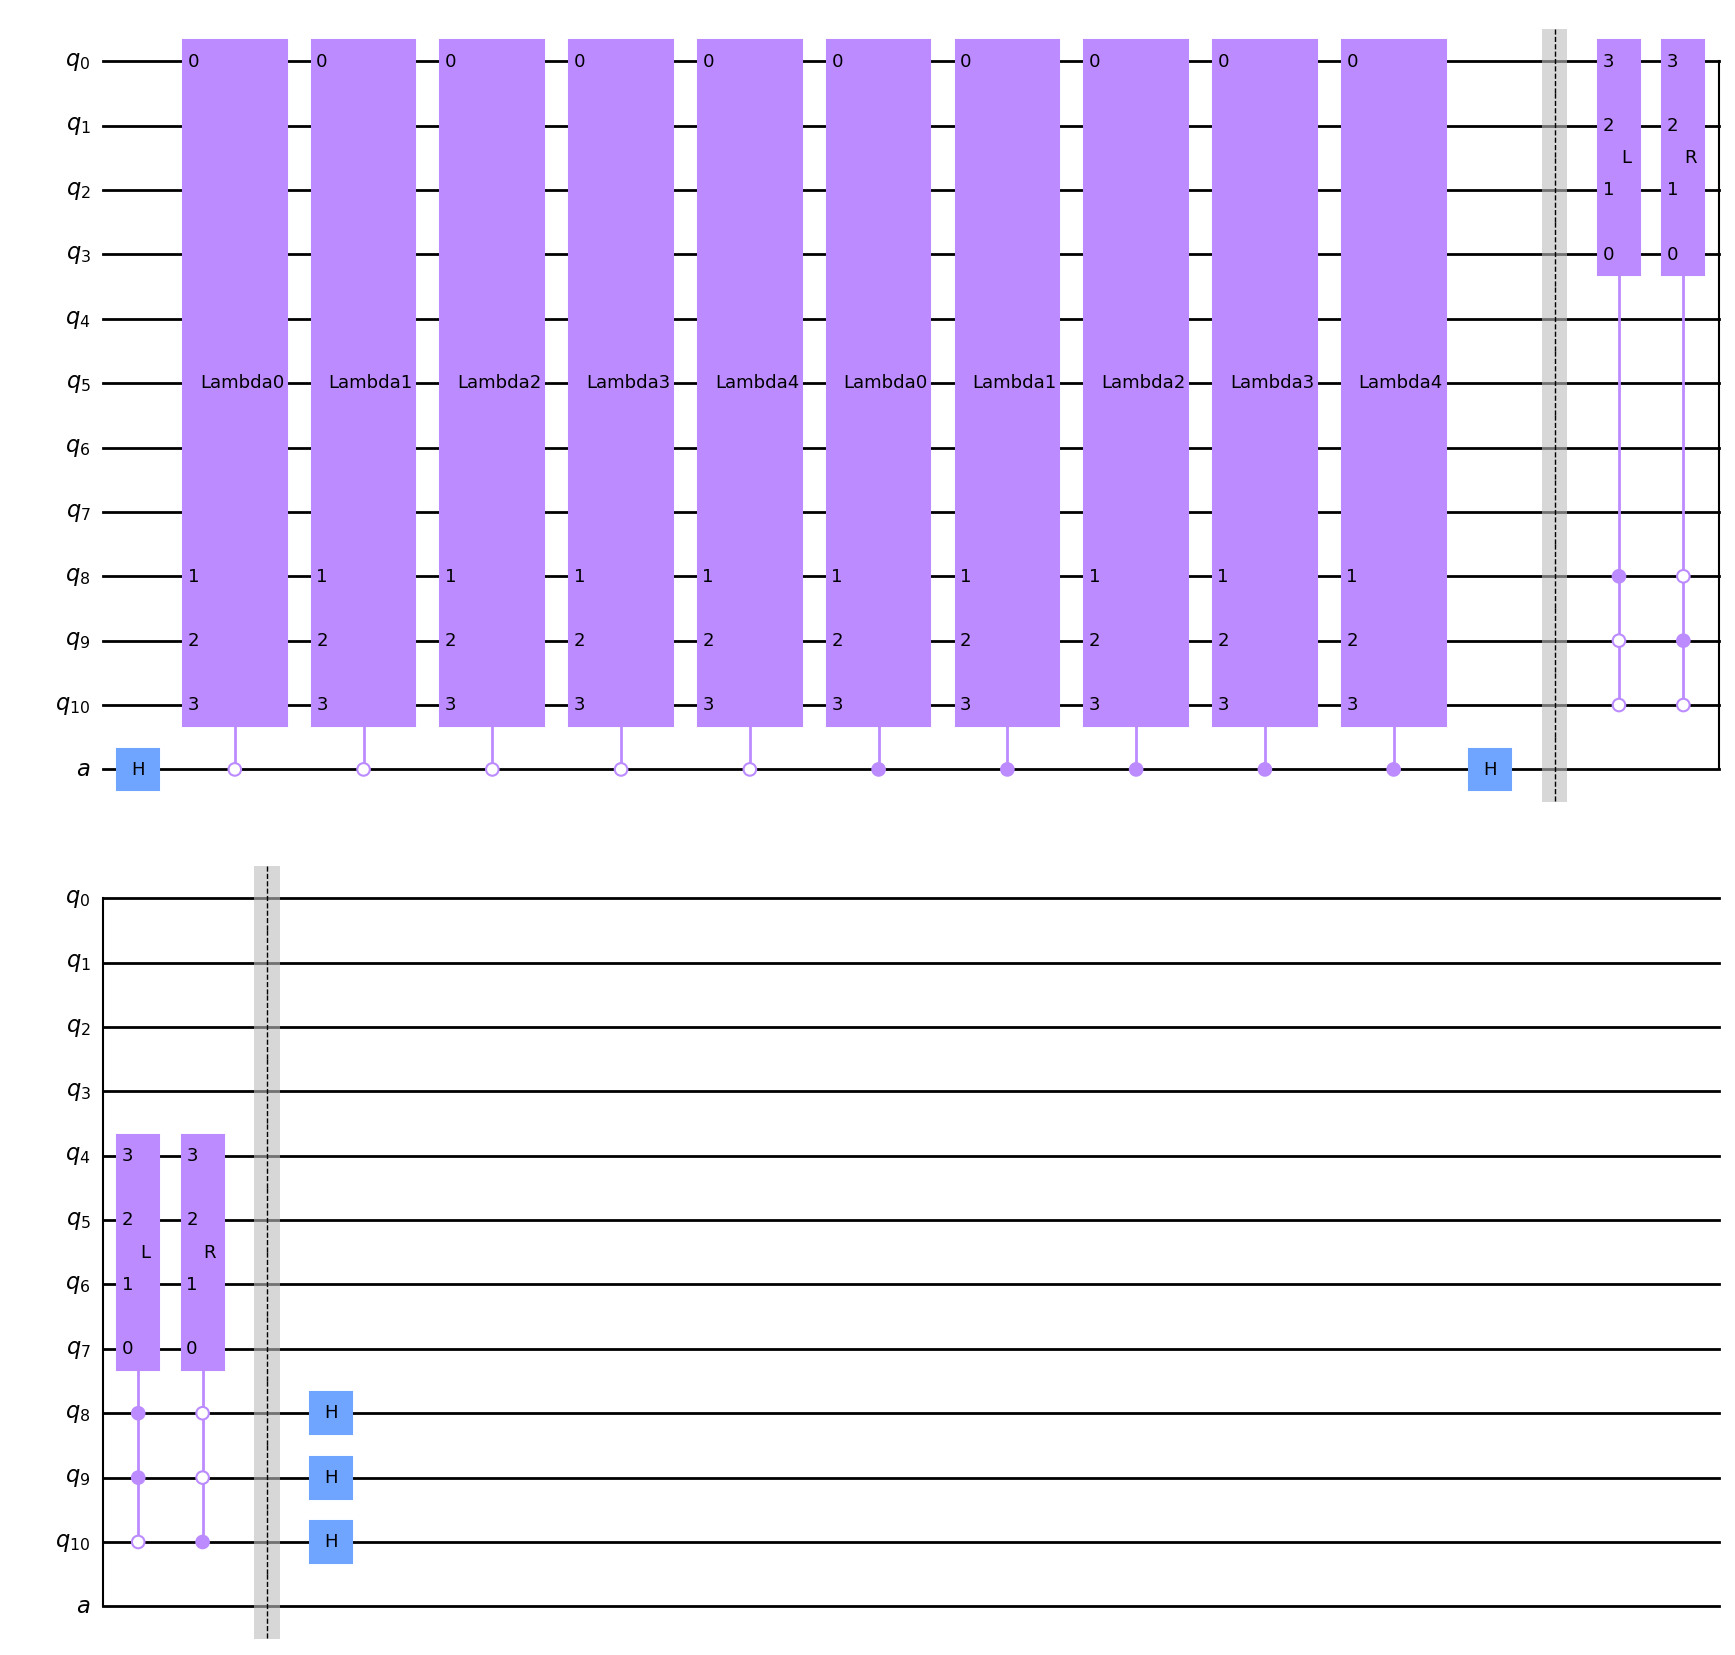

In [5]:
q = QuantumRegister(nlinks+dim*nlat,'q')
a = AncillaRegister(1,'a')

setup = QuantumCircuit(q)
setup.add_register(a)


cb = [a,0]
cb.extend([i for i in range(dim*nlat, dim*nlat+nlinks)])
setup.h(a)
for i in range(dirs):
    setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
for i in range(dirs):
    setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
setup.h(a)

setup.barrier()
L1 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '001')
R1 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '010')
L2 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '011')
R2 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '100')
setup.append(L1,[8,9,10,3,2,1,0])
setup.append(R1,[8,9,10,3,2,1,0])
setup.append(L2,[8,9,10,7,6,5,4])
setup.append(R2,[8,9,10,7,6,5,4])
setup.barrier()

setup.h(8)
setup.h(9)
setup.h(10)


setup.draw()#.savefig('qd215.pdf')

In [6]:
def reinit(ar):
    br = ar.copy()
    for i in range(dirs-1):
        br = np.concatenate((br,ar.copy()))
    for i in range(2**nlinks-dirs):
        br = np.concatenate((br,np.zeros(M*M)))
    return br,np.linalg.norm(br)

In [7]:
#### initialState
state = np.ones(M*M)/10  #0.1 everywhere
state[4*M+4] = 0.3    # 4,4 is 0.3

In [8]:
def timestep(sv):
    return sv.evolve(setup)

def graph(sv,col):
    for i in range(16):
        plt.plot(list(range(i*int(M*M/16),(i+1)*int(M*M/16))), np.array(sv)[i*int(M*M/16):(i+1)*int(M*M/16)],color = col)

def graph3d(st):
    arax = [i for i in range(16)]
    unflat = []
    for i in range(16):
        tmpa = st[16*i:16*(i+1)]
        unflat.append(tmpa)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(arax, arax, unflat, 50, cmap='binary')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('C');

In [9]:
allstates = []

expstate, nrm = reinit(state)
SV = Statevector(expstate/nrm).expand([1,0])
# graph3d(state) # initial state
allstates.append(state)
state = np.array(timestep(SV))[:M*M]
state = state*np.sqrt(8)*nrm
# graph3d(state)
allstates.append(state)

colors = ['red','green','purple','pink','brown']
for i in range(21):
    expstate, nrm = reinit(state)
    SV = Statevector(expstate/nrm).expand([1,0])
    state = np.array(timestep(SV))[:M*M]
    state = state*np.sqrt(8)*nrm
    allstates.append(state)
#     graph(state, colors[i])
#     if i%5==0:
#         graph3d(state)


In [10]:
def graphC(state,it,levels = 3):
    arax = [i for i in range(16)]
    unflat = []
    for i in range(16):
        tmpa = state[16*i:16*(i+1)]
        unflat.append(tmpa)
    fig, ax = plt.subplots()
    CS = ax.contour(arax, arax, unflat,levels = levels)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('t='+str(it))
    ax.set_aspect('equal', adjustable='box')

/Users/sriharshakocherla/miniforge3/envs/quantum/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/sriharshakocherla/miniforge3/envs/quantum/lib/python3.11/site-packages/numpy/ma/core.py:2859: ComplexWarning: Casting complex values to real discards the imaginary part
  [getmaskarray(np.asanyarray(m, dtype=_data.dtype))


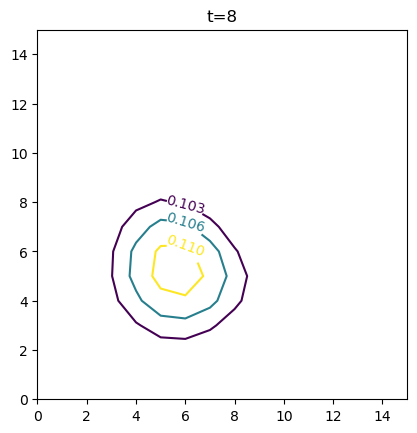

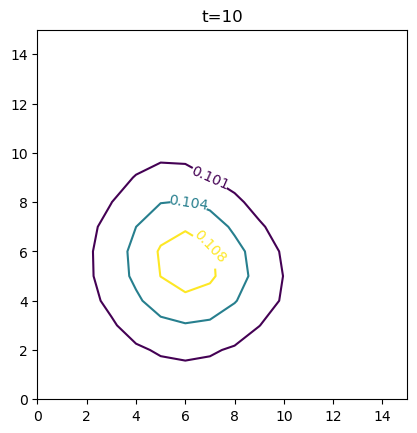

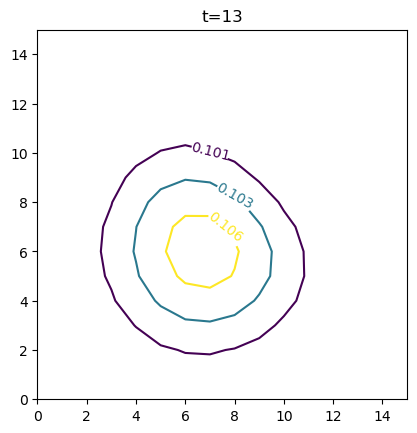

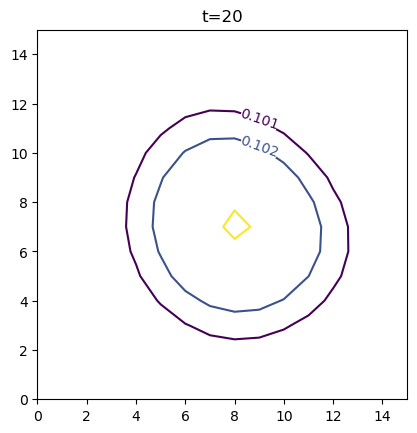

In [11]:
graphC(allstates[8],8,[0.103,0.106,0.11])
graphC(allstates[10],10,[0.101,0.104,0.108])
graphC(allstates[13],13,[0.101,0.103,0.106])
graphC(allstates[20],20,[0.101,0.102,0.105])

In [12]:
# graphC(allstates[10],10)

In [13]:
for i in range(len(allstates)):
    np.savetxt('d2q5/'+str(i+1)+'.csv', np.real(allstates[i]), delimiter=',')

In [14]:
print(len(allstates))

23
